# testing.ipynb

This notebook loads truth and reco level data from the prepped h5 files, fits the data using the pre-trained keras model of choice, and outputs data similar to what would be found in the KLFitter.

## Imports

In [1]:
import numpy as np
import vector
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
# from tensorflow.keras import regularizers 
# from tensorflow.keras import initializers
import h5py
import os 
from clr_callback import *
# from tensorflow.keras.callbacks import TensorBoard
# import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Choosing and Loading Files

In [2]:
# Choose model
model_name = 'Model_Custom'
#model_name = 'Model_Custom+ttbar'
#model_name = 'Model_JetPretrain+ttbar'
model = keras.models.load_model(model_name+'/'+model_name+'_full_6j.keras')

# Choose which data type to look at
#data_type = 'parton_ejets'
#data_type = 'parton_mjets'
#data_type = '_sysUP'
#data_type = '_sysDOWN'
data_type = '_6j'

# Dataset
#dataset = h5py.File('/data/jchishol/ML_Data/variables_ttbar_'+data_type+'_test.h5','r')
#dataset = h5py.File('/mnt/xrootdg/jchishol/mntuples_08_01_22/variables_ttbar_ljets_jetMatch04_6jets_test.h5','r')
dataset = h5py.File('/mnt/xrootdg/jchishol/mntuples_08_01_22/variables_ttbar_ljets'+data_type+'_test.h5','r')

# Numpy array of [max,mean] for each variable
#X_maxmean = np.load(model_name+'/X_maxmean_parton_e+mjets_train.npy')  # should always use this same file I think?
#Y_maxmean = np.load(model_name+'/Y_maxmean_parton_e+mjets_train.npy')
#X_maxmean_dic = np.load('X_maxmean_variables_ttbar_ljets_jetMatch04_6jets_train.npy',allow_pickle=True).item()  # should always use this same file I think?
#Y_maxmean_dic = np.load('Y_maxmean_variables_ttbar_ljets_jetMatch04_6jets_train.npy',allow_pickle=True).item()
X_maxmean_dic = np.load('X_maxmean_variables_ttbar_ljets_6j_train.npy',allow_pickle=True).item()  # should always use this same file I think?
Y_maxmean_dic = np.load('Y_maxmean_variables_ttbar_ljets_6j_train.npy',allow_pickle=True).item()


2023-01-26 11:13:23.158682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-01-26 11:13:23.158706: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-26 11:13:23.159019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Useful Variables

In [3]:
# Number of events in dataset
size = np.array(dataset.get('met_met')).size
crop0 = size

# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
if '+ttbar' in model_name: 
    Y_keys = Y_keys + ['ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m']
if 'JetPretrain' in model_name: 
    Y_keys = ['j1_isTruth','j2_isTruth','j3_isTruth','j4_isTruth','j5_isTruth','j6_isTruth'] + Y_keys

print(Y_keys)

# Variable keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Get the maxmean values we actually need for this particular model
xmm_keys = list(X_maxmean_dic.keys())
if model_name == 'Model_Custom':
    ymm_keys = [key for key in Y_maxmean_dic.keys() if 'isTruth' not in key and 'ttbar' not in key]
elif model_name == 'Model_Custom+ttbar':
    ymm_keys = [key for key in Y_maxmean_dic.keys() if 'isTruth' not in key]
else:
    ymm_keys = list(Y_maxmean_dic.keys())
X_maxmean = np.array([X_maxmean_dic[key] for key in xmm_keys])
Y_maxmean = np.array([Y_maxmean_dic[key] for key in ymm_keys])

print(crop0)

['th_pt', 'th_eta', 'th_phi', 'th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
3616038


## Import Helper Codes

In [4]:
import normalize
import shape_timesteps
importlib.reload(normalize)
importlib.reload(shape_timesteps)

# Loss function needed for model fitting (check this with training ... feel like we use it here but not there)
#def loss_fc(true, pred):
#        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))

<module 'shape_timesteps' from '/home/jchishol/TRecNet/shape_timesteps.py'>

## Scale the Data

In [7]:
# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables(phi_keys,dataset,crop0)
X_total, X_names = Scaler.scale_arrays(dataset,X_keys, X_maxmean,crop0)
Y_total, Y_names = Scaler.scale_arrays(dataset,Y_keys, Y_maxmean,crop0)

In [8]:
if model_name=='Model_JetPretrain+ttbar':
    # And don't want jet pretraining variables later
    #Y_total = Y_total[:,6:]
    #Y_names = Y_names[6:]
    Y_maxmean = Y_maxmean[6:]
    print(Y_names)

## Split and Fit Data

In [12]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
#split1 = int(np.floor(0.70*crop0))
#split2 = int(np.floor(0.85*crop0))

# Split into training, validation, and testing data for Y
#trainY, valY, testY = Y_total[0:split1,:], Y_total[split1:split2,:], Y_total[split2:,:]
#print("Training:",trainY.size/Y_total.size)
#print("Validation:",valY.size/Y_total.size)
#print("Testing:",testY.size/Y_total.size)

testY = Y_total

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
testX_jets, testX_other = timestep_builder.reshape_X(dataset,X_total, X_names,phi_keys,crop0, False,True)

# Split into training, validation, and testing data for jets and other
#trainX_jets, valX_jets, testX_jets = totalX_jets[0:split1,:,:], totalX_jets[split1:split2,:,:], totalX_jets[split2:,:,:]
#trainX_other, valX_other, testX_other = totalX_other[0:split1,:], totalX_other[split1:split2,:], totalX_other[split2:,:]

In [13]:
# Define bins
# Need for a sec ( I think ):
Y_names = ymm_keys[6:]

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Load machine learning model
#model = keras.models.load_model(model_name+'.keras', custom_objects={'loss_fc':loss_fc})
#model = keras.models.load_model(model_name+'.keras')


# Predictions and truth BEFORE they're back to the original scale
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY

predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)



#dataset.close()

  3514/113002 [..............................] - ETA: 7:17

KeyboardInterrupt: 

In [ ]:
from observables import norm, cross, dot
from transform import Transform
import uproot

if model_name=='Model_JetPretrain+ttbar':
    pred_keys = Y_keys[6:]
else:
    pred_keys = Y_keys

# We're going to turn this into dataframes for easier reading
truth_keys = list(dataset.keys())[43:-8]
truth_keys.extend(('eventNumber','jet_n'))
truths = pd.DataFrame({key:dataset.get(key) for key in truth_keys})  # or something like this
truths_check = pd.DataFrame(true_origscale,columns=pred_keys)
preds = pd.DataFrame(predictions_origscale,columns=pred_keys)

for var in [truths_check,preds]:   # then get rid of this loop
    
    # Create the 4-vectors for hadronic and leptonic tops
    th_vec = vector.arr({"pt": var['th_pt'], "phi": var['th_phi'], "eta": var['th_eta'],"mass": var['th_m']})
    tl_vec = vector.arr({"pt": var['tl_pt'], "phi": var['tl_phi'], "eta": var['tl_eta'],"mass": var['tl_m']}) 
    
    # Create 4-vector for ttbar (and get ttbar variables if necessary)
    if '+ttbar' in model_name:
        ttbar_vec = vector.arr({"pt": var['ttbar_pt'], "phi": var['ttbar_phi'], "eta": var['ttbar_eta'],"mass": var['ttbar_m']})
    else:
        ttbar_vec = th_vec + tl_vec
        var['ttbar_pt'] = ttbar_vec.pt
        var['ttbar_phi'] = ttbar_vec.phi
        var['ttbar_eta'] = ttbar_vec.eta
        var['ttbar_m'] = ttbar_vec.m
    
    # Get vector package to calculate the energies
    var['th_E'] = th_vec.energy
    var['tl_E'] = tl_vec.energy
    var['ttbar_E'] = ttbar_vec.energy
    
    # Get vector package to calculate the rapidities
    var['th_y'] = th_vec.rapidity
    var['tl_y'] = tl_vec.rapidity
    var['ttbar_y'] = ttbar_vec.rapidity
    
    # Calculate pout for th and tl
    ez = vector.arr({"px":np.array([0]*var['th_eta'].shape[0]),"py":np.array([0]*var['th_eta'].shape[0]),"pz":np.array([1]*var['th_eta'].shape[0])})
    thP_vec = vector.arr({"px":th_vec.px,"py":th_vec.py,"pz":th_vec.pz})
    tlP_vec = vector.arr({"px":tl_vec.px,"py":tl_vec.py,"pz":tl_vec.pz})
    var['th_pout'] = -thP_vec.dot(tlP_vec.cross(ez)/(tlP_vec.cross(ez).mag))   # For some reason this calculation is off by a negative compared to the truth ...
    var['tl_pout'] = -tlP_vec.dot(thP_vec.cross(ez)/(thP_vec.cross(ez).mag))

    # Calculate some other ttbar variables
    var['ttbar_dphi'] = abs(th_vec.deltaphi(tl_vec))
    var['ttbar_Ht'] = var['th_pt']+var['tl_pt']
    var['ttbar_yboost'] = 0.5*(var['th_y']+var['tl_y'])
    var['ttbar_ystar'] = 0.5*(var['th_y']-var['tl_y'])
    var['ttbar_chi'] = np.exp(2*np.abs(var['ttbar_ystar']))
    
    var['eventNumber'] = dataset.get('eventNumber')
    var['jet_n'] = dataset.get('jet_n')
    
# Save as a tree root file
final_keys = list(truths.keys())
results_file = uproot.recreate('/mnt/xrootdg/jchishol/'+model_name+'_full_Results.root')
results_file["reco"] = {final_keys[i]:preds[final_keys[i]] for i in range(len(final_keys))}
results_file["parton"] = {final_keys[i]:truths[final_keys[i]] for i in range(len(final_keys))}

In [13]:
from observables import norm, cross, dot
from transform import Transform
import uproot

if model_name=='Model_JetPretrain+ttbar':
    pred_keys = Y_keys[6:]
else:
    pred_keys = Y_keys

# We're going to turn this into dataframes for easier reading

preds = pd.DataFrame(predictions_origscale,columns=Y_keys)

for var in [preds]:   # then get rid of this loop
    
    # Create the 4-vectors for hadronic and leptonic tops
    th_vec = vector.arr({"pt": var['th_pt'], "phi": var['th_phi'], "eta": var['th_eta'],"mass": var['th_m']})
    tl_vec = vector.arr({"pt": var['tl_pt'], "phi": var['tl_phi'], "eta": var['tl_eta'],"mass": var['tl_m']}) 
    
    # Create 4-vector for ttbar (and get ttbar variables if necessary)
    if '+ttbar' in model_name:
        ttbar_vec = vector.arr({"pt": var['ttbar_pt'], "phi": var['ttbar_phi'], "eta": var['ttbar_eta'],"mass": var['ttbar_m']})
    else:
        ttbar_vec = th_vec + tl_vec
        var['ttbar_pt'] = ttbar_vec.pt
        var['ttbar_phi'] = ttbar_vec.phi
        var['ttbar_eta'] = ttbar_vec.eta
        var['ttbar_m'] = ttbar_vec.m
    
    # Get vector package to calculate the energies
    var['th_E'] = th_vec.energy
    var['tl_E'] = tl_vec.energy
    var['ttbar_E'] = ttbar_vec.energy
    
    # Get vector package to calculate the rapidities
    var['th_y'] = th_vec.rapidity
    var['tl_y'] = tl_vec.rapidity
    var['ttbar_y'] = ttbar_vec.rapidity
    
    # Calculate pout for th and tl
    ez = vector.arr({"px":np.array([0]*var['th_eta'].shape[0]),"py":np.array([0]*var['th_eta'].shape[0]),"pz":np.array([1]*var['th_eta'].shape[0])})
    thP_vec = vector.arr({"px":th_vec.px,"py":th_vec.py,"pz":th_vec.pz})
    tlP_vec = vector.arr({"px":tl_vec.px,"py":tl_vec.py,"pz":tl_vec.pz})
    var['th_pout'] = -thP_vec.dot(tlP_vec.cross(ez)/(tlP_vec.cross(ez).mag))   # For some reason this calculation is off by a negative compared to the truth ...
    var['tl_pout'] = -tlP_vec.dot(thP_vec.cross(ez)/(thP_vec.cross(ez).mag))

    # Calculate some other ttbar variables
    var['ttbar_dphi'] = abs(th_vec.deltaphi(tl_vec))
    var['ttbar_Ht'] = var['th_pt']+var['tl_pt']
    var['ttbar_yboost'] = 0.5*(var['th_y']+var['tl_y'])
    var['ttbar_ystar'] = 0.5*(var['th_y']-var['tl_y'])
    var['ttbar_chi'] = np.exp(2*np.abs(var['ttbar_ystar']))
    
    var['eventNumber'] = dataset.get('eventNumber')
    #var['jet_n'] = dataset.get('jet_n')
    
# Save as a tree root file
final_keys = list(Y_keys)
results_file = uproot.recreate('/mnt/xrootdg/jchishol/mntuples_08_01_22/'+model_name+data_type+'_Results.root')
results_file["reco"] = {final_keys[i]:preds[final_keys[i]] for i in range(len(final_keys))}
#results_file["parton"] = {final_keys[i]:truths[final_keys[i]] for i in range(len(final_keys))}

ValueError: Shape of passed values is (1, 20), indices imply (1, 26)

## Plot Truth vs Predictions

/tmp/ipykernel_3127524/3753612491.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(col)


True


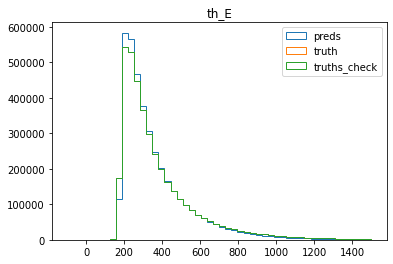

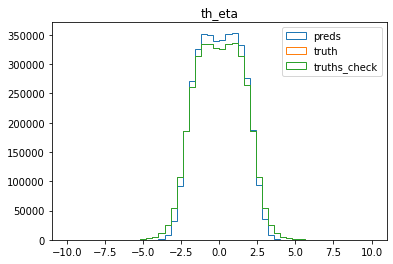

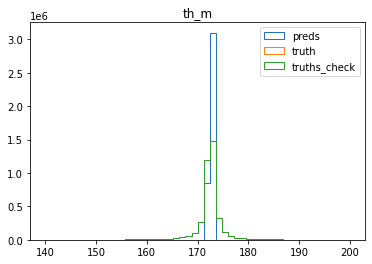

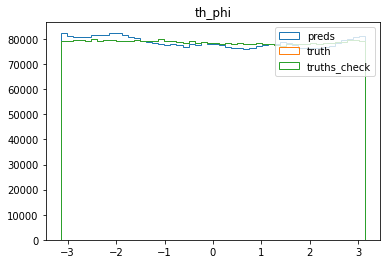

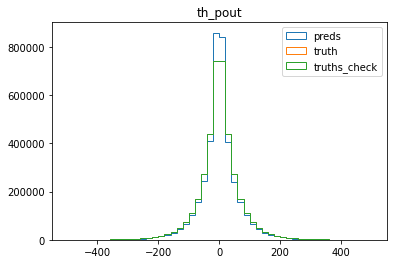

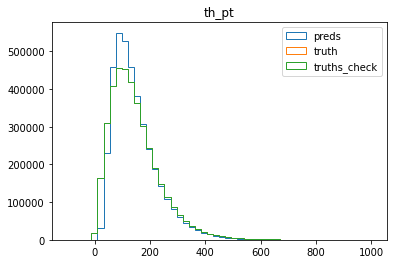

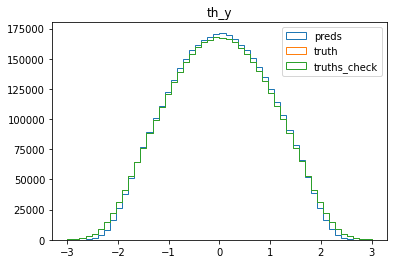

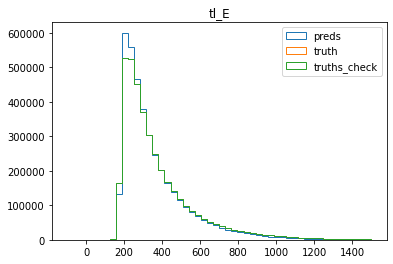

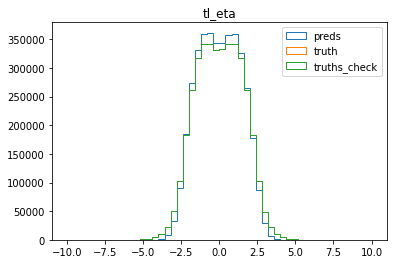

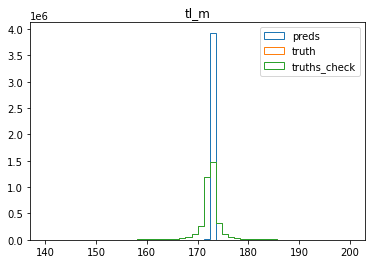

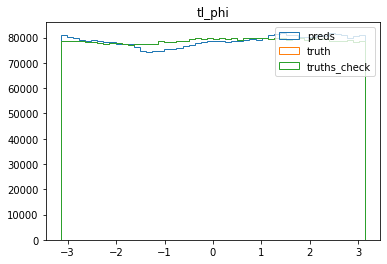

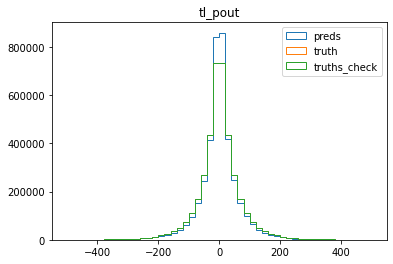

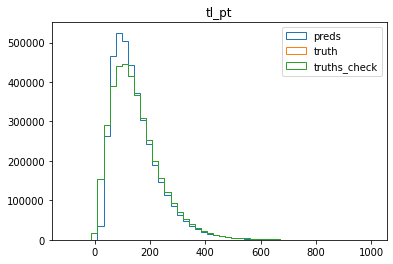

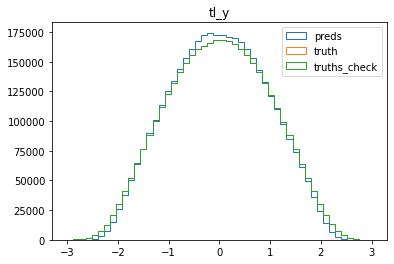

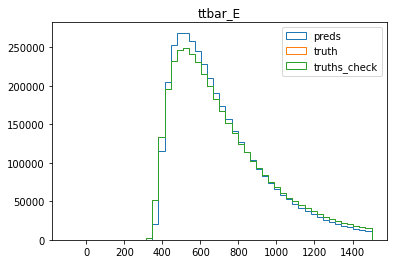

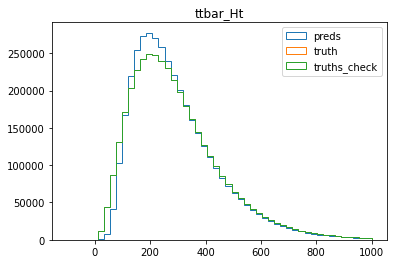

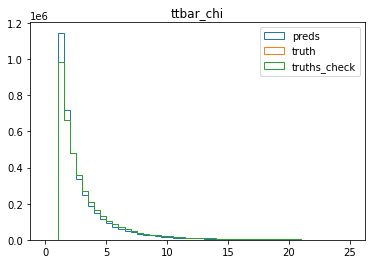

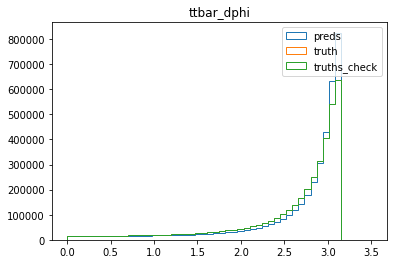

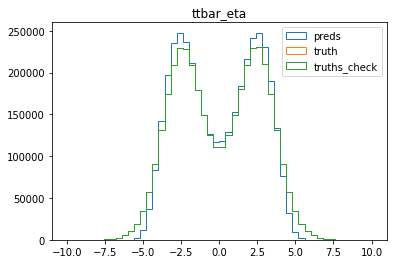

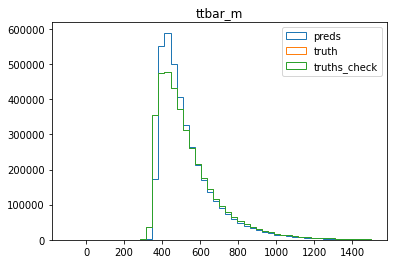

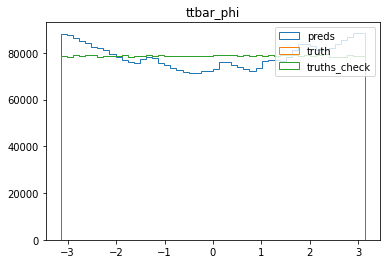

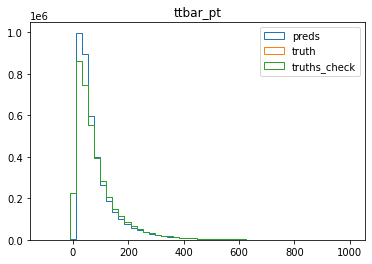

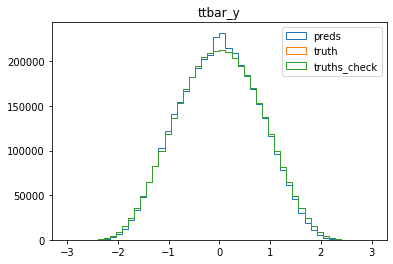

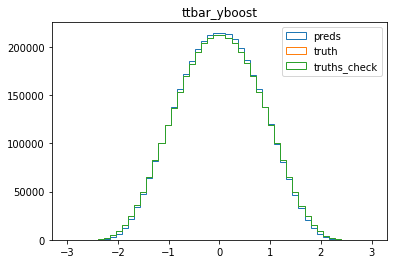

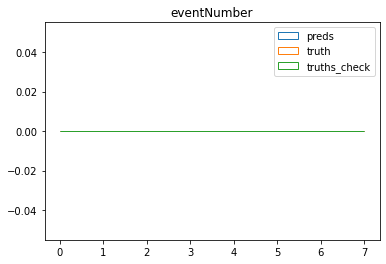

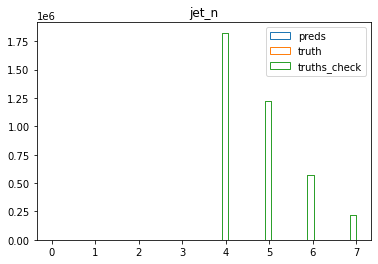

In [17]:
#Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
for col in final_keys:
    
    if col in ['th_pt','tl_pt','wh_pt','wl_pt','ttbar_pt','ttbar_Ht']:
        r = (-100,1000)
    elif col in ['th_E','tl_E','ttbar_E','ttbar_m']:
        r = (-100,1500)
    elif col in ['th_eta','tl_eta','wh_eta','wl_eta','ttbar_eta']:
        r = (-10,10)
    elif col in ['th_phi','tl_phi','wh_phi','wl_phi','ttbar_phi']:
        r = (-3.14,3.14)
    elif col in ['th_pout','tl_pout','ttbar_pout']:
        r = (-500,500)
    elif col in ['th_m','tl_m']:
        r = (140,200)
    elif col in ['wh_m','wl_m']:
        r = (0,200)
    elif col in ['ttbar_m']:
        r = (0,1500)
    elif col in ['th_y','tl_y','ttbar_yboost','ttbar_ystar','ttbar_y']:
        r = (-3,3)
    elif col in ['ttbar_dphi']:
        r = (0,3.5)
    elif col in ['ttbar_chi']:
        r = (0,25)
    else:
        r = (0,7)

    
    # Create
    plt.figure(col)
    
    # Plot new data
    plt.title(col)
    plt.hist(preds[col],bins=50,range=r,histtype='step')
    plt.hist(truths[col],bins=50,range=r,histtype='step')
    plt.hist(truths_check[col],bins=50,range=r,histtype='step')
    plt.legend(['preds','truth','truths_check'])

print(len(preds)==len(truths))


In [13]:
print(truths['ttbar_phi'])
print(truths_check['ttbar_phi'])

0        -0.153168
1         1.018162
2        -0.533384
3        -2.415080
4        -0.181309
            ...   
993887    1.247271
993888   -2.315965
993889   -0.862802
993890    2.257085
993891   -1.973456
Name: ttbar_phi, Length: 993892, dtype: float32
0        -0.153168
1         1.018162
2        -0.533384
3        -2.415080
4        -0.181309
            ...   
993887    1.247271
993888   -2.315965
993889   -0.862802
993890    2.257085
993891   -1.973456
Name: ttbar_phi, Length: 993892, dtype: float64


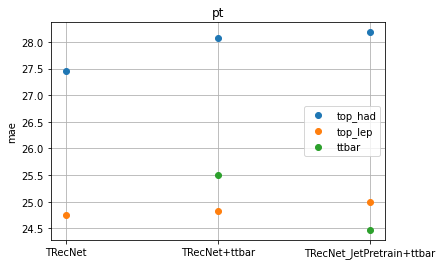

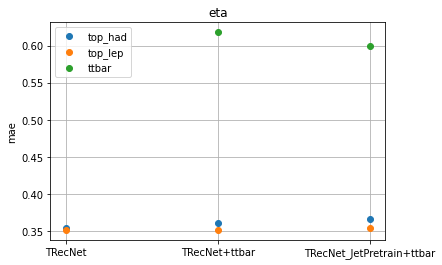

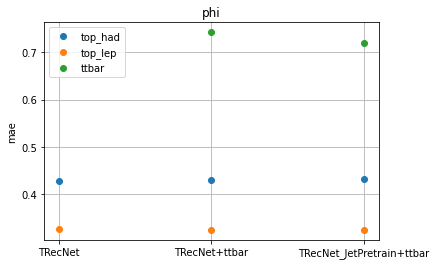

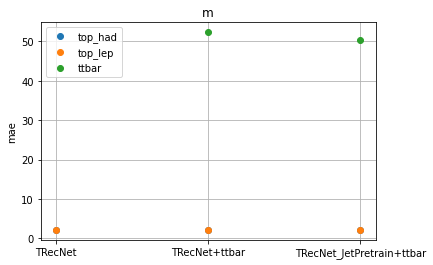

In [13]:
TRecNet_Errors = np.load('Model_Custom/Model_Custom_Errors.npy',allow_pickle=True).item()
TRecNet_ttbar_Errors = np.load('Model_Custom+ttbar/Model_Custom+ttbar_Errors.npy',allow_pickle=True).item()
TRecNet_JetPretrain_ttbar_Errors = np.load('Model_JetPretrain+ttbar/Model_Custom_JetPretrain+ttbar_Errors.npy',allow_pickle=True).item()
x = [1,2,3]
ticks = ['TRecNet','TRecNet+ttbar','TRecNet_JetPretrain+ttbar']

err = 'mae'

for var in ['pt','eta','phi','m']:
    plt.figure(var)
    plt.title(var)
    plt.plot(x,[TRecNet_Errors['th_'+var][err],TRecNet_ttbar_Errors['th_'+var][err],TRecNet_JetPretrain_ttbar_Errors['th_'+var][err]],'o',label='top_had')
    plt.plot(x,[TRecNet_Errors['tl_'+var][err],TRecNet_ttbar_Errors['tl_'+var][err],TRecNet_JetPretrain_ttbar_Errors['tl_'+var][err]],'o',label='top_lep')
    plt.plot([2,3],[TRecNet_ttbar_Errors['ttbar_'+var][err],TRecNet_JetPretrain_ttbar_Errors['ttbar_'+var][err]],'o',label='ttbar')
    plt.xticks(x,ticks)
    plt.ylabel(err)
    plt.grid()
    plt.legend()
